## COMPUTE VERTICAL PROFILES AND TGSD

This script computes vertical profiles for the velocity and volumetric concentration of particles given depth-averaged values in terms of:

- flow thickness $h$;
- depth-averaged velocity $u_{avg}$ or depth-averaged mass flux $(\rho u)_{avg}$;
- total depth-averaged volumetric fraction of particles $\alpha_s^{tot}$;
- TGSD parameters (mean size $\mu$ and standard deviation $\sigma$ in phi scale.

The density of solid particles changes linearly in the phi scale between a minimum a maximum value, defined by additional input parameters:
$$
\rho(\phi) = \begin{cases}
    \rho_1 & \text{if } \phi<\phi_1 \\
    \rho_1 + \frac{\phi - \phi1}{\phi_2 - \phi1} \rho_2 & \text{if } \phi_1\leq \phi\leq \phi_1 \\
    \rho_2 & \text{if } \phi>\phi_2
\end{cases}
$$

In addition, density and kinematic visocisty of the gas and gravitational acceleration should be provided.

These parameters are defined in the next code block.

In [1]:
%reset -f

# flow thickness [m]
h = 8.00

# depth averaged velocity [m/s]
u_avg = 20.0 # depth

# depth-averaged u(z)*rhom(z)  [kg/(m2 s)]
# uRho_avg = 50.0

# Total volumetric fraction of solid particles
# alphas_tot = 0.005

# depth-averaged mixture density [kg/m3]
rhom = 10.0


# The TGSD is defined by a normal distribution in the phi scale
# Parameters of the normal TGSD
mu = 2
sig = 1.0

# Particle Densities parameters:
phi1 = -2
rho1 = 1000.0
phi2 = 3
rho2 = 2200.0

# Classes of particle sizes
phi_min = -1
phi_max = 5
nsolid = 10

# gas density [kg/m3]
rhog = 1.1

# gas kinematic viscosity [m2/s]
kin_visc = 1.48e-5

# gravitational acceleration [m/s2]
grav = 9.81

# Von Karman constant
k = 0.4

# friction coefficient
friction_coeff = 0.01

# substrate roughness [m]
k_s = 1.5

# ratio of momentum and mass diffusivity (Schmidt number)
beta_sc = 1.0

# parameters for the convergence of the iterative solution procedure
rel_tol = 1.e-10
abs_tol = 1.e-8


In [2]:
# check on input
if ('uRho_avg' in locals()) and ('u_avg' in locals()):

    print('Please specify ONLY one among u_avg or uRho_avg')

elif 'u_avg' in locals():

    print('Using u_avg')

elif 'uRho_avg' in locals():

    print('Using uRho_avg')

else:

    print('Please specify one among u_avg or uRho_avg')

if ('rhom' in locals()) and ('alphas_tot' in locals()):

    print('Please specify ONLY one among rhom or alphas_tot')

elif 'rhom' in locals():

    print('Using rhom')

elif 'alphas_tot' in locals():

    print('Using alphas_tot')

else:

    print('Please specify one among rhom or alphas_tot')


Using u_avg
Using rhom


Several Python packages are needed.

In [3]:
# Import Libraries

import scipy.special as sc
from mpmath import * ; mp.dps = 15 ; mp.pretty = True
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw # imports the lambert function and returns complex result
from scipy import integrate        # allows us to use the exponential integral function
from scipy.stats import norm

The function *Settling_Velocity()* in the following block takes the inputs:

• rhos - The density of each solid class $\left(\frac{kg}{m^3}\right)$

• rhog - The density of the gas phase $\left(\frac{kg}{m^3}\right)$

• diam - The diameter of each class of particles (meters)

• grav - The gravitational Constant - 9.81 $\left(\frac{m}{s^2}\right)$

• kin_visc - The Kinematic Viscosity of gas (units)


If the density of the solid phase is less than the gasous phase, a check is included which sets the settling velocity to 0.

Otherwise, the settling velocity is computed via the following function:

The settling velocity, as a function of the size of the particles, satisfy the following relationship:

$$
    v_s(d_s) = \sqrt{\frac{4}{3} \frac{d_s g}{C_D({\rm Re})} \left(\frac{\rho_s-\rho_a}{\rho_a}\right)}.
$$

Please note that the drag coefficient $C_D$ is a function of the Reynolds number $Re== \frac{d_s v_s}{\nu}$, and thus of the settling velocity, through the following equation.

$$
C_D({\rm Re}) = \frac{24}{\rm Re} \left( 1 + 0.15 {\rm Re}^{0.687} \right)
$$

For this reason, the following function adopts an iterative procedure to compute the settling velocity.

In [4]:
# Settling Velocity

def settling_velocity(rhos, rhog, diam, grav, kin_visc):
    inv_sqrt_C_D = 1.0
    settl_vel = np.zeros_like(rhos)
    for i in range(0, len(phi)):

        if rhos[i] <= rhog:
            settl_vel[i] = 0.0

        else:

            const_part = np.sqrt(0.75 * (rhos[i] / rhog - 1.0) * diam[i] *
                                 grav)
            settl_vel[i] = const_part * inv_sqrt_C_D
            Rey = diam[i] * settl_vel[i] / kin_visc

            for j in range(20):
                inv_sqrt_C_D = np.sqrt(Rey / (24.0 *
                                              (1.0 + 0.15 * Rey**0.687)))
                settl_vel[i] = const_part * inv_sqrt_C_D
                Rey = diam[i] * settl_vel[i] / kin_visc

    return settl_vel

The next function compute the relative mass fractions of the solid classes from the parameters of the size distribution.

In [5]:
# Total Grain Size Distribution
def TGSD(mu, sig, phi):
    n_bins = len(phi)
    xs = norm.cdf(0.5 * (phi[0:len(phi) - 1] + phi[1:len(phi)]), mu, sig)
    xs = np.append(xs, [1])
    xs[1:len(phi)] = np.diff(xs)

    return xs

This function compute the density of a class of particles, given the size in the phi scale.

In [6]:
# Particle Density Computation
def part_dens(phi, phi1, rho1, phi2, rho2):

    rhos = rho1 * (phi < phi1) + (phi >= phi1) * (
        rho1 + (rho2 - rho1) * np.minimum(1.0, (phi - phi1) / (phi2 - phi1)))

    return rhos

# Compute average profiles

def avg_profiles_mix(h, settl_vel, k, friction_coeff, rhoalpha_avg, u_guess,
                     beta_sc, h0, b, u_coeff, u_rel0, rhos, rhog):

    u_star = u_guess * np.sqrt(friction_coeff)
    Pn = settl_vel / (k * u_star)
    nsolid = len(settl_vel)
    rho_u_alphas = np.zeros(nsolid)
    rhoalphas_int = np.zeros(nsolid)

    for i in range(len(settl_vel)):

        a = -(6.0 * Pn[i] * beta_sc) / h
        a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)
        int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

        alphas_rel_max = 1.0 / int_
        alphas_rel0 = alphas_rel_max * np.exp(a * h0)

        rhoalphas_int[i] = rhoalpha_avg[i] * \
            (alphas_rel_max * (np.exp(a*h0) - 1.0) / a + (h-h0)*alphas_rel0) / h

        y = h0
        int_h0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                  np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        y = 0
        int_0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                 np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        int_def = u_coeff * np.sqrt(friction_coeff) / \
            k * alphas_rel_max * (int_h0-int_0)

        rho_u_alphas[i] = rhoalpha_avg[i] * u_guess * \
            (int_def + (h - h0) * alphas_rel0 * u_rel0) / h

    rhom_avg = rhog + sum((rhos - rhog) / rhos * rhoalphas_int)
    uRho_avg_new = (u_guess * rhog + sum((rhos - rhog) / rhos * rho_u_alphas))

    return rhom_avg, uRho_avg_new

In [40]:
# Compute average profiles

def avg_profiles_mix(h, settl_vel, k, friction_coeff, rhoalpha_avg, u_guess,
                     beta_sc, h0, b, u_coeff, u_rel0, rhos, rhog):

    u_star = u_guess * np.sqrt(friction_coeff)
    Pn = settl_vel / (k * u_star)
    nsolid = len(settl_vel)
    rho_u_alphas = np.zeros(nsolid)
    rhoalphas_int = np.zeros(nsolid)
    
    d_bl = h0
    epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
    a = -(k * u_star * Pn) / epsilon_s

    
#---------------------------------------------------------

    # Calculate the Average Concentration from the depth-averaged rhom

    C_bar = alpha_avg 
    C_Coeff = 1 # Set to one for now 

    nz = 1000
    z = np.linspace(0, h, nz+1)
    dz = h / nz

    # d_bl_element = np.round((h0*h)*(nz/10) -1)
    d_bl_element = (h0/h)*len(z)

    C_z = np.zeros([nz+1, nsolid])

    for j in range(len(settl_vel)):
        for i in range(nz):
            C_z[i,j] = C_bar[j] * C_Coeff * np.exp(a[j]*z[i])
    C_z[int(d_bl_element+1):,:] = C_z[int(d_bl_element),:]        

#------------------------------------------------------------------------------

# Compute C_Coeff for each particle class

    C_coeff = alpha_avg / ((sum(C_z)*dz)/h)
    # print('C_coeff = ', np.round(C_coeff,3))

    for j in range(len(settl_vel)):
        C_z[:,j] = C_z[:,j] * C_coeff[j]
        
    for i in range(len(settl_vel)):

        # a = -(6.0 * Pn[i] * beta_sc) / h
        # a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)
        # int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

        alphas_rel_max = C_z[0,:]
        alphas_rel0 =  C_z[int(d_bl_element),:]

        rhoalphas_int[i] = sum(rhos[i] * ((C_z[:,i])*dz))/h

        y = h0
        int_h0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                  np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        y = 0
        int_0 = (np.exp(a * y) * np.log(b * y + 1.0) +
                 np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

        int_def = u_coeff * np.sqrt(friction_coeff) / \
            k * alphas_rel_max * (int_h0-int_0)

        rho_u_alphas[i] = rhoalpha_avg[i] * u_guess * (sum(C_z[:,i])*dz) / h

    rhom_avg = rhog + sum((rhos - rhog) / rhos * rhoalphas_int)
    uRho_avg_new = (u_guess * rhog + sum((rhos - rhog) / rhos * rho_u_alphas))

    return rhom_avg, uRho_avg_new

# Code and Outputs

In [41]:
# Numpy array of phi solid classes
phi = np.linspace(phi_min, phi_max, nsolid)

# Relative mass fractions of the particle classes (sum=1)
xs_rel = TGSD(mu, sig, phi)

# Density of the solid classes
rhos = part_dens(phi, phi1, rho1, phi2, rho2)

# Average density of solid particles [kg/m3]
rhos_tot = 1.0 / (sum(xs_rel / rhos))

# Particles diameters [m]
diam = (1.0e-3) * 2**(-phi)

# Particles settling velocities [m/s]
settl_vel = settling_velocity(rhos, rhog, diam, grav, kin_visc)

if 'rhom' in locals():

    # total volume fraction of solid in the gas-solid mixture
    alphas_tot = ( rhom - rhog ) / ( rhos_tot - rhog )

    print('Total solid volume fraction computed from rhom',
      '                   =', alphas_tot)

else:

    # Gas-particles mixture density [kg/m3]
    rhom = alphas_tot * rhos_tot + (1.0 - alphas_tot) * rhog

    print('Mixture density computed from mass fractions (kg/m3)',
      '                   =', rhom)

# Total solid mass fraction [kg/kg]
xs_tot = alphas_tot * rhos_tot / rhom

# Solid mass fraction of solid classes in the mixture [kg/kg]
xs = xs_rel * xs_tot


# Depth-averaged volumetric fractions
alpha_avg = xs / rhos * rhom

for i in range(0, nsolid):
    print('Depth-averaged alpha(1) computed from xs', '[', i + 1, ']',
          '             =', round(alpha_avg[i], 15))

print(
    'Total solid depth-averaged volume fraction computed from mass fractions =',
    sum(alpha_avg))

# this is the depth-averaged value of rhos*alpha(z), which is equal to the
# depth-averaged  value  of xs*rhom(z). So it is the conservative variable
# used for the solid mass divided by h.
rhoAlpha_avg = rhos * alpha_avg


Total solid volume fraction computed from rhom                    = 0.004648523269181925
Depth-averaged alpha(1) computed from xs [ 1 ]              = 2.7508042924e-05
Depth-averaged alpha(1) computed from xs [ 2 ]              = 0.000120344665059
Depth-averaged alpha(1) computed from xs [ 3 ]              = 0.000390803684921
Depth-averaged alpha(1) computed from xs [ 4 ]              = 0.000835016523583
Depth-averaged alpha(1) computed from xs [ 5 ]              = 0.00117238405024
Depth-averaged alpha(1) computed from xs [ 6 ]              = 0.001080432360025
Depth-averaged alpha(1) computed from xs [ 7 ]              = 0.000652831100255
Depth-averaged alpha(1) computed from xs [ 8 ]              = 0.000277115340217
Depth-averaged alpha(1) computed from xs [ 9 ]              = 7.6582968674e-05
Depth-averaged alpha(1) computed from xs [ 10 ]              = 1.5504533285e-05
Total solid depth-averaged volume fraction computed from mass fractions = 0.004648523269181925


The thickness of the turbulent boundary layer and the presence (or absence) of a free-stream region depends on several factors. It can be shown that there exists a critical flow thickness $H_{crit}$, above which a free-stream region is required, while below the critical thickness the velocity has a logarithmic profile for the entire flow thickness. This critical thickness is given by
$$
H_{crit} = \frac{k_s}{30} \left( \frac{a}{\mathcal{W}(-ae^{-a})} - 1 \right),
$$
where $a = \frac{\kappa}{\sqrt{C_f}}$ and $\mathcal{W}$ is the Lambert function.

It is easier to work with a non-dimensional height $h^{rel}=\frac{h}{k_s}$, which also results in a non-dimensional critical thickness:
$$
H_{crit}^{rel} = \frac{1}{30} \left( \frac{a}{\mathcal{W}(-ae^{-a})} - 1 \right).
$$

In [42]:
# H_crit is a critical thickness above  which there is a constant free stream
# velocity. Below  H_crit  we  only  have  the  log  profile. H_crit is a
# function of k, k_s and friction_coeff only. H_crit_rel  is  the
# non-dimensional crtitical thickness, which depends on k and the friction
# coefficient only

# The profile parameters depend on h/k_s, not on the absolute value of h.
h_rel = h / k_s

a = k / np.sqrt(friction_coeff) + 1.0
H_crit_rel = np.real(1.0 / 30.0 * (-a / lambertw(-a * np.exp(-a)) - 1.0))
print('Log region thickness (meters)    =', round(H_crit_rel * k_s, 13))

Log region thickness (meters)    = 7.1162460797028


We define now the relative thickness of the turbulent boundary layer which is:


In [43]:
if (h_rel > H_crit_rel):

    # we search for h0_rel such that the average integral between 0 and
    # h_rel is equal to 1. For h_rel > H_crit_rel  this  integral is the
    # sum of  two  pieces:  integral  between  0  and h0_rel of the log
    # profile integral between h0_rel and h_rel of  the costant profile

    a = h_rel * k / np.sqrt(friction_coeff)
    b = 1.0 / 30.0 + h_rel
    c = 30.0

    # solve b*log(c*z+1)-z=a for z
    d = a / b - 1.0 / (b * c)

    h0_rel = np.real(-b * lambertw(-np.exp(d) / (b * c)) - 1.0 / c)
    u_coeff = 1.0

else:

    # when h_rel <= H_crit_rel we have only the log profile and we have to
    # rescale it in order to have the integral between o and h_rel equal to 1
    # The factor used to scale the velocity is u_coeff

    h0_rel = h_rel
    u_coeff = k / np.sqrt(friction_coeff) / (
        (1 + 1 / (30 * h_rel)) * np.log(30.0 * h_rel + 1.0) - 1.0)

h0 = h0_rel * k_s
b = 30.0 / k_s
u_rel0 = u_coeff * np.sqrt(friction_coeff) / k * np.log(b * h0 + 1.0)

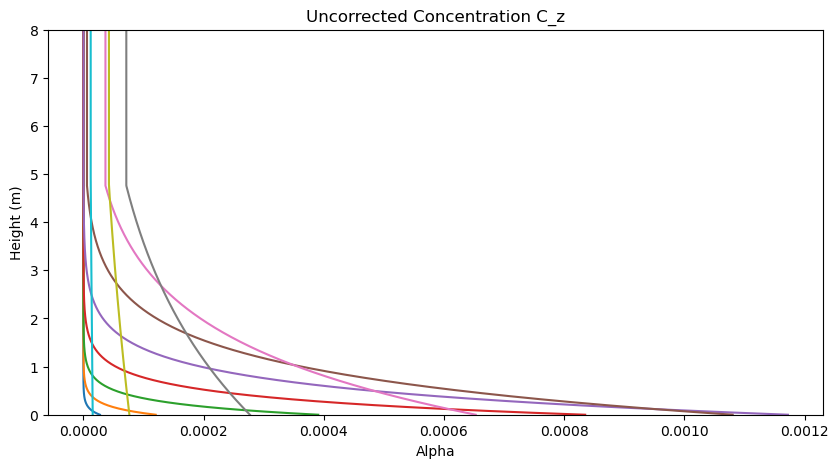

C_coeff =  [59.366 43.745 31.375 21.698 14.232  8.57   4.579  2.321  1.48   1.181]


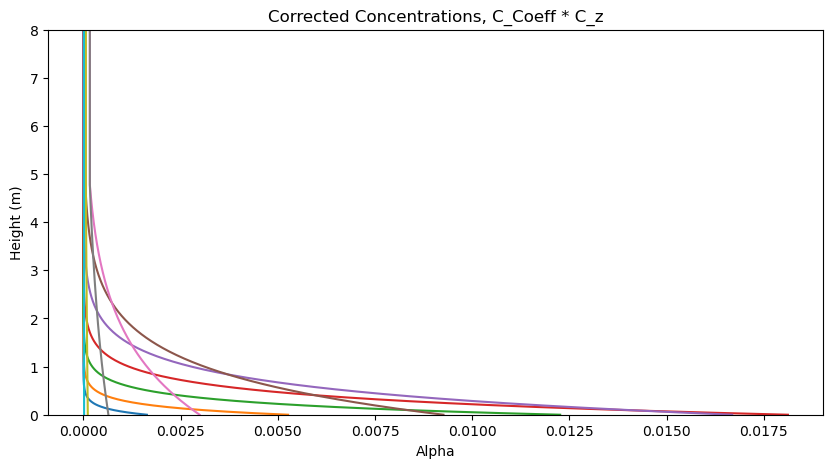

2.750804292424733e-05
[2.75080429e-05 1.20344665e-04 3.90803685e-04 8.35016524e-04
 1.17238405e-03 1.08043236e-03 6.52831100e-04 2.77115340e-04
 7.65829687e-05 1.55045333e-05]


In [44]:
# Compute the concentration profile 

u_star = u_avg * np.sqrt(friction_coeff)
Pn = settl_vel / (k * u_star)
nsolid = len(settl_vel)
rho_u_alphas = np.zeros(nsolid)
rhoalphas_int = np.zeros(nsolid)

d_bl = h0
epsilon_s = beta_sc * u_star * d_bl / (6.0 * (k * d_bl + k_s / 10.0))
a = -(k * u_star * Pn) / epsilon_s

# Calculate the Average Concentration from the depth-averaged rhom

C_bar = alpha_avg 
C_Coeff = 1 # Set to one for now 

nz = 1000
z = np.linspace(0, h, nz+1)
dz = h / nz

# d_bl_element = np.round((h0*h)*(nz/10) -1)
d_bl_element = (h0/h)*len(z)

C_z = np.zeros([nz+1, nsolid])

for j in range(len(settl_vel)):
    for i in range(nz):
        C_z[i,j] = C_bar[j] * C_Coeff * np.exp(a[j]*z[i])
        
C_z[int(d_bl_element+1):,:] = C_z[int(d_bl_element),:]        
        

# Create the plot
plt.figure(figsize=(10, 5))  # Optional: set the size of the figure
for i in range(nsolid):
    plt.plot(C_z[:,i],z)
    # plt.plot(0.00001,h0,'.',markersize=25,) # Plots a marker at the boundary layer height
    
plt.title('Uncorrected Concentration C_z')
plt.xlabel('Alpha')
plt.ylabel('Height (m)')
plt.ylim([0,h])
plt.show() 


# print(sum(C_z*dz))
# print(alpha_avg)

#------------------------------------------------------------------------------

# Compute C_Coeff for each particle class

# a = 6 * k * Pn / beta_sc * ( k * (d_bl**2) + ((k_s * d_bl)/10))
#C_coeff = alpha_avg / (C_z[0,:] * ((1 - np.exp(-a*h))/(a*h)))
# C_coeff = h / ( ((np.exp(-a*d_bl) -1) / a) + (np.exp(-a*d_bl)) * (h - d_bl))

for i in range(0,nsolid):
    C_coeff[i] = alpha_avg[i] / ((sum(C_z[:,i])*dz)/h)
print('C_coeff = ', np.round(C_coeff,3))

for j in range(len(settl_vel)):
    C_z[:,j] = C_z[:,j] * C_coeff[j]

# Create the plot
plt.figure(figsize=(10, 5))  # Optional: set the size of the figure
for i in range(nsolid):
    plt.plot(C_z[:,i],z)
    
plt.title('Corrected Concentrations, C_Coeff * C_z')
plt.xlabel('Alpha')
plt.ylabel('Height (m)')
plt.ylim([0,h])
plt.show()


print(sum(C_z[:,0]*dz)/h)
print(alpha_avg)


In [45]:
if 'uRho_avg' in locals():

    # search convergence of u_avg
    n = 200

    u_avg_guess = uRho_avg / rhom
    x0 = u_avg_guess

    # loop to compute the average velocity from average rho*alpha and average
    # uRho ( = 1/h*int( u*rhog*alphag + sum[u*rhos(i)*alphas(i)] ) )
    print()
    #     avg_profiles_mix function returns ([rhom_avg,uRho_avg_new])

    for i in range(0, n):

        x0 = u_avg_guess

        rhom_avg, uRho_avg_new = avg_profiles_mix(h, settl_vel, k,
                                                  friction_coeff, rhoAlpha_avg,
                                                  u_avg_guess, beta_sc, h0, b,
                                                  u_coeff, u_rel0, rhos, rhog)

        u_avg_new = u_avg_guess * uRho_avg / (uRho_avg_new)

        x1 = u_avg_new

        rhom_avg, uRho_avg_new = avg_profiles_mix(h, settl_vel, k,
                                                  friction_coeff, rhoAlpha_avg,
                                                  u_avg_new, beta_sc, h0, b,
                                                  u_coeff, u_rel0, rhos, rhog)

        u_avg_new = u_avg_new * uRho_avg / (uRho_avg_new)

        x2 = u_avg_new

        if (x1 != x0):
            # OPTIONAL: Computes an approximation of |f'(fixedPoint)|, which is
            # denoted by lambda
            lambda_ = abs((x2 - x1) / (x1 - x0))

        denominator = (x2 - x1) - (x1 - x0)

        # To avoid greatly increasing error, do not divide by too small of a
        # number
        if (abs(denominator) < 0.1 * abs_tol):
            print('')
            print('                     –––––––                      ')
            print('****************** Ending Loop *******************')
            print('******** WARNING: denominator is too small *******')
            break  # Leave the loop

        aitkenX = x2 - ((x2 - x1)**2) / denominator

        u_avg_new = aitkenX

        if (abs(u_avg_guess - u_avg_new) / u_avg_guess <
                rel_tol) or (abs(u_avg_guess - u_avg_new) < abs_tol):
            u_avg_guess = u_avg_new

        u_avg_guess = u_avg_new

        print('Iteration #', i + 1, '–––> u_guess =', round(u_avg_new, 14),
              ' m/s')

    print('                     –––––––                      ')
    print('                                                         ')
    print('Total Iterations           = ', i)
    print('u_final                    = ', round(u_avg_new, 13), 'm/s')
    print('Depth-averaged rho         = ', round(rhom_avg, 12), 'kg/m3')

    # average velocity
    u_avg = u_avg_new

rhom_avg, uRho_avg = avg_profiles_mix(h, settl_vel, k, friction_coeff,
                                      rhoAlpha_avg, u_avg, beta_sc, h0, b,
                                      u_coeff, u_rel0, rhos, rhog)

# shear velocty
u_star = u_avg * np.sqrt(friction_coeff)

# Rouse numbers for different particles
Pn = settl_vel / (k * u_star)


Iteration # 1 –––> u_guess = 20.0  m/s

                     –––––––                      
****************** Ending Loop *******************
******** WARNING: denominator is too small *******
                     –––––––                      
                                                         
Total Iterations           =  1
u_final                    =  20.0 m/s
Depth-averaged rho         =  10.0 kg/m3


In [46]:
## Check for average values, computed from u_avg and alpha_avg(i)

# average velocity computed as integral of the profile
U_int = (u_avg *
         (u_coeff * np.sqrt(friction_coeff) / k *
          ((h0 + 1.0 / b) * np.log(b * h0 + 1) - h0) + (h - h0) * u_rel0)) / h

print()
print('Depth-averaged u (m/s)            = ', round(U_int, 15))
print('Depth-averaged rho (kg/m3)            = ', round(rhom_avg, 15))

uAlpha_int = np.zeros(nsolid)
uRhoAlpha_int = np.zeros(nsolid)

for i in range(0, nsolid):

    a = -(6.0 * Pn[i] * beta_sc) / h
    a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)
    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

    alpha_rel_max = 1.0 / int_
    alpha_rel0 = alpha_rel_max * np.exp(a * h0)

    # average concentration of particle class i
    alpha_int = alpha_avg[i] * (alpha_rel_max * (np.exp(a * h0) - 1.0) / a +
                                (h - h0) * alpha_rel0) / h

    print('Depth-averaged alphas [', i, ']       = ', round(alpha_int, 15))

    y = h0
    int_h0 = (np.exp(a * y) * np.log(b * y + 1.0) +
              np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

    y = 0
    int_0 = (np.exp(a * y) * np.log(b * y + 1.0) +
             np.exp(-a / b) * sc.exp1(-a * (y + 1.0 / b))) / a

    int_def = u_coeff * np.sqrt(friction_coeff) / \
        k * alpha_rel_max * (int_h0-int_0)

    # average of u*alphas(i)
    uAlpha_int[i] = u_avg * alpha_avg[i] * \
        (int_def + (h - h0) * alpha_rel0 * u_rel0) / h
    uRhoAlpha_int[i] = rhos[i] * alpha_avg[i] * u_avg * \
        (int_def + (h - h0) * alpha_rel0 * u_rel0) / h

uAlpha_int_tot = sum(uAlpha_int)
uRhoAlpha_int_tot = sum(uRhoAlpha_int)
rho_u_int_tot = rhog * U_int + sum((rhos - rhog) / rhos * uRhoAlpha_int)

# print('Depth-averaged u*alpha            = ',round(uAlpha_int_tot,15)    )
print('Depth-averaged rho*u (kg m-2 s-1) = ', rho_u_int_tot)


Depth-averaged u (m/s)            =  20.0
Depth-averaged rho (kg/m3)            =  9.99999999999988
Depth-averaged alphas [ 0 ]       =  2.7508042924e-05
Depth-averaged alphas [ 1 ]       =  0.000120344665059
Depth-averaged alphas [ 2 ]       =  0.000390803684921
Depth-averaged alphas [ 3 ]       =  0.000835016523583
Depth-averaged alphas [ 4 ]       =  0.00117238405024
Depth-averaged alphas [ 5 ]       =  0.001080432360025
Depth-averaged alphas [ 6 ]       =  0.000652831100255
Depth-averaged alphas [ 7 ]       =  0.000277115340217
Depth-averaged alphas [ 8 ]       =  7.6582968674e-05
Depth-averaged alphas [ 9 ]       =  1.5504533285e-05
Depth-averaged rho*u (kg m-2 s-1) =  141.02570465667398


(alpha_bottom [ 0 ]) / (alpha_avg [ 0 ]) = 0.001633046702584101
(alpha_bottom [ 1 ]) / (alpha_avg [ 1 ]) = 0.0052645230035881195
(alpha_bottom [ 2 ]) / (alpha_avg [ 2 ]) = 0.012261525693740657
(alpha_bottom [ 3 ]) / (alpha_avg [ 3 ]) = 0.018118269198199078
(alpha_bottom [ 4 ]) / (alpha_avg [ 4 ]) = 0.01668580104628874
(alpha_bottom [ 5 ]) / (alpha_avg [ 5 ]) = 0.009259741690853375
(alpha_bottom [ 6 ]) / (alpha_avg [ 6 ]) = 0.00298912194021115
(alpha_bottom [ 7 ]) / (alpha_avg [ 7 ]) = 0.0006432346499696897
(alpha_bottom [ 8 ]) / (alpha_avg [ 8 ]) = 0.0001133293382683659
(alpha_bottom [ 9 ]) / (alpha_avg [ 9 ]) = 1.830550611634466e-05
Rhom_avg =  9.99999999999988
rhog =  1.1
rhos =  [1240. 1400. 1560. 1720. 1880. 2040. 2200. 2200. 2200. 2200.]
rho_tot = [119.32667339 116.96143701 114.65889722 ...   2.11585387   2.11585387
   2.11585387]
Mean rho_tot = 9.996217158437654


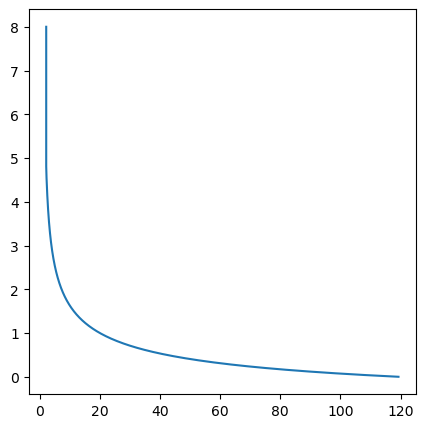

In [61]:
nz = 1000
z = np.linspace(0, h, nz+1)
dz = h / nz

# u_rel is the velocity profile with depth-average equal to 1 when u_rel is
# multiplied by u the depth-averaged value is the desired one u_rel is defined
# for 0<=z<=h_rel, thus it is  defined  for  the  rescaled  depth.  This  does
# not affect the depth-average value

u_rel = u_coeff * np.sqrt(friction_coeff) / k * \
    np.log(30.0/k_s*np.minimum(h0, z) + 1.0)

# u_rel_half = 0.5*(u_rel(2:end)+u_rel(1:end-1))

uualpha = 0.0 * u_rel

p_dyn = np.zeros_like(u_rel)
rho = np.zeros([len(u_rel),nsolid])
rho_tot = np.zeros_like(u_rel)
alphas_bottom = np.zeros(nsolid)
alphag = 1.0 - 0.0 * z

for i in range(0, nsolid):

    a = -(6.0 * Pn[i] * beta_sc) / h
    a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)

    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h
    alpha_rel_max = C_z[0,:]
    alphas_bottom[i] = C_z[0,i]

    print('(alpha_bottom [', i, '])', '/ (alpha_avg [', i, '])', '=',
          alpha_rel_max[i])

    alpha_rel = C_z[int(d_bl_element),:]

    rho[:,i] = (C_z[:,i] * rhos[i])

    #p_dyn += 0.5 * (rho) * (u_avg * u_rel) * (u_avg * u_rel)

    # p_dyn += 0.5 * (alphag * rhog) * (u_avg * u_rel) * (u_avg * u_rel)

    #alphag = 1 - sum(C_z[:,:])
    #rho += alphag * rhog

    # rhoalphas[i] = rhos[i] * ((C_z[:,i]))
    #(rhos - rhog) / rhos * (sum(rhos[i] * ((C_z[:,i])*dz)))

for i in range(0,len(u_rel)):
    rho_tot[i] = sum(rho[i,:])
    
rho_tot = rho_tot + (alphag*rhog)
p_dyn = 0.5*rho_tot*(u_avg * u_rel) * (u_avg * u_rel)

plt.figure(figsize=(5, 5))  # Optional: set the size of the figure
plt.plot(rho_tot,z)    

print('Rhom_avg = ', rhom_avg)
print('rhog = ', rhog)
print('rhos = ', rhos)
print('rho_tot =', rho_tot)
print('Mean rho_tot =', np.mean(rho_tot))

In [62]:
uuAlpha_avg = 0.0

for i in range(0, nsolid):

    a = -(6.0 * Pn[i] * beta_sc) / h
    a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)
    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

    alpha_rel_max = 1.0 / int_

    # use use a quadrature formula for the log region
    def f(z):
        return np.exp(a * z) * (np.log(30.0 / k_s * z + 1.0))**2

    uuAlpha_avg = uuAlpha_avg + (
        alpha_rel_max * u_coeff * np.sqrt(friction_coeff) / k *
        integrate.quadrature(f, 0, h0)[0] + u_rel0 * u_rel0 * alpha_rel0 *
        (h - h0)) * alpha_avg[i] * u_avg**2 / h

print('Depth-averaged u*u*c =', uuAlpha_avg, '(m^2)/(s^2)')

Depth-averaged u*u*c = 4.09142813932431 (m^2)/(s^2)


In [63]:
# Mixture density at the bottom
rhom_bottom = sum(alphas_bottom * rhos) + (1.0 - sum(alphas_bottom)) * rhog

# Solid mass fractions (in the mixture) at the bottom
xs_bottom = (alphas_bottom * rhos) / rhom_bottom

# Gas mass fraction (in the mixture) at the bottom
xg_bottom = 1.0 - sum(xs_bottom)

# Relative solid mass fractions at the bottom (sum=1 => TGSD)
xs_rel_bottom = xs_bottom / (1.0 - xg_bottom)

# Mean size of TGSD at the bottom
mu_bottom = sum(phi * xs_rel_bottom)

print('Mean size at bottom =', mu_bottom)

Mean size at bottom = 1.3162422227161392


In [64]:
# Rates of mass lost from the flow at the bottom (propirtional to density,

# volume fraction at the bottom and settling velocity)
xs_rel_lost = (rhos * alphas_bottom * settl_vel)

# Normalization to have sum=1 (TGSD)
xs_rel_lost = (xs_rel_lost / sum(xs_rel_lost))

# Mean side of TGSD lost at the base of the flow
mu_lost = sum(phi * xs_rel_lost)

print('Mean size lost at the base of the flow = phi \n', mu_lost)

Mean size lost at the base of the flow = phi 
 0.7910414317174733


(0.0, 8.0)

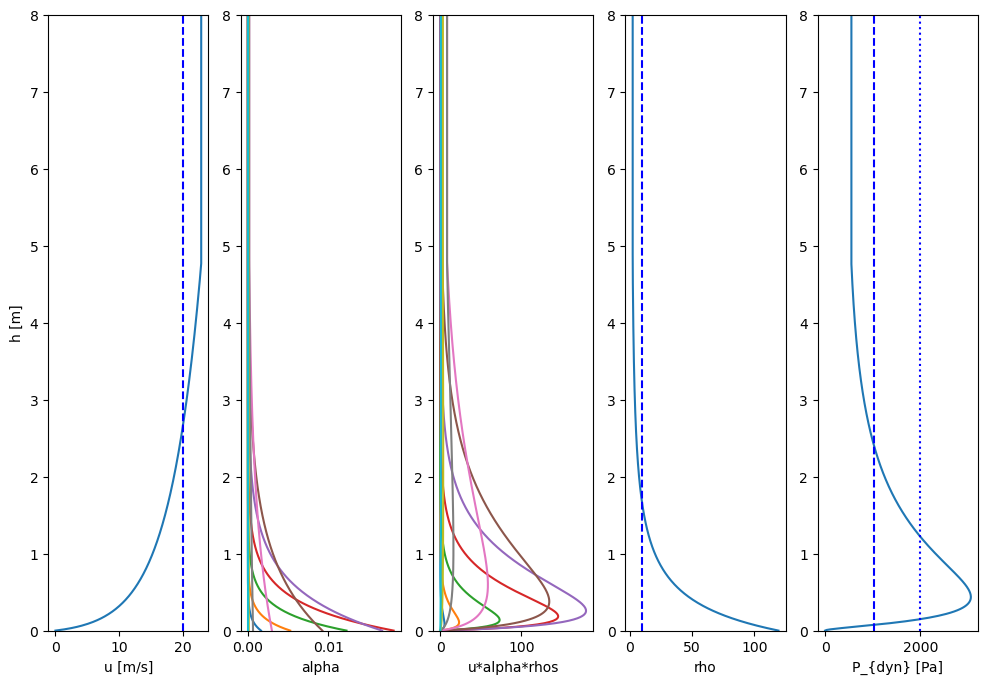

In [65]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

u_rel = u_coeff * sqrt(friction_coeff) / k * \
    np.log(30.0/k_s*np.minimum(h0, z) + 1.0)

ax1.plot(u_avg * u_rel,z)
ax1.plot(np.ones(nz+1)*u_avg,z,'b--')

ax1.set(xlabel='u [m/s]', ylabel='h [m]')

ax1.set_ylim(0, h)

for i in range(nsolid):

    a = -(6 * Pn[i] * beta_sc) / h
    a = -Pn[i] * beta_sc / ((k_s / 30) / 2 + h / 6.0)

    int_ = ((np.exp(a * h0) - 1.0) / a + np.exp(a * h0) * (h - h0)) / h

    alpha_rel_max = 1.0 / int_

    alpha_rel = alpha_rel_max * np.exp(a * (np.minimum(h0, z)))

    uualpha = uualpha + (u_avg * u_rel) * (u_avg * u_rel) * (alpha_avg[i] *
                                                             alpha_rel)

    ax2.plot(C_z[:,i], z)

    ax3.plot((u_avg * u_rel) * (C_z[:,i]) * rhos[i], z)

ax2.set(xlabel='alpha')
ax2.set_ylim(0, h)

ax3.set(xlabel='u*alpha*rhos')
ax3.set_ylim(0, h)

ax4.plot(rho_tot, z)
ax4.plot(rhom*np.ones(nz+1),z,'b--')
ax4.set(xlabel='rho')
ax4.set_ylim(0, h)

#p_dyn = 


ax5.plot(p_dyn, z)

p_dyn_avg1 = np.mean(p_dyn)
p_dyn_avg2 = 0.5*rhom*u_avg**2

ax5.plot(p_dyn_avg1*np.ones(nz+1), z,'b--')
ax5.plot(p_dyn_avg2*np.ones(nz+1), z,'b:')


ax5.set(xlabel='P_{dyn} [Pa]')
ax5.set_ylim(0, h)


In [66]:
# Mixture density at the bottom
rhom_bottom = sum(alphas_bottom * rhos) + (1.0 - sum(alphas_bottom)) * rhog

# Solid mass fractions (in the mixture) at the bottom
xs_bottom = (alphas_bottom * rhos) / rhom_bottom

# Gas mass fraction (in the mixture) at the bottom
xg_bottom = 1.0 - sum(xs_bottom)

# Relative solid mass fractions at the bottom (sum=1 => TGSD)
xs_rel_bottom = xs_bottom / (1.0 - xg_bottom)

# Mean size of TGSD at the bottom
mu_bottom = sum(phi * xs_rel_bottom)
print('Mean size at bottom =', mu_bottom)

Mean size at bottom = 1.3162422227161392


In [67]:
# Rates of mass lost from the flow at the bottom (propirtional to density,
# volume fraction at the bottom and settling velocity)
xs_rel_lost = (rhos * alphas_bottom * settl_vel)
# Normalization to have sum=1 (TGSD)
xs_rel_lost = (xs_rel_lost / sum(xs_rel_lost))

# Mean side of TGSD lost at the base of the flow
mu_lost = sum(phi * xs_rel_lost)

print('Mean size lost at the base of the flow = #e phi \n', mu_lost)

Mean size lost at the base of the flow = #e phi 
 0.7910414317174733


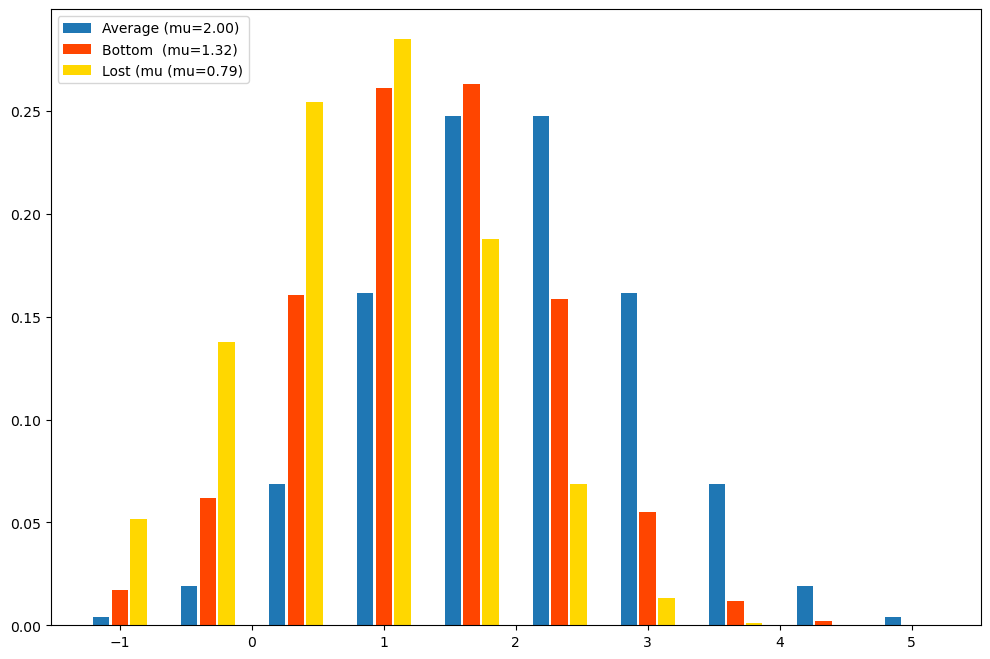

In [68]:
fig
barwidth = 0.125

phi_avg = phi
phi_bottom = phi
phi_lost = phi

phi_avg = phi - barwidth * (1.125)
phi_bottom = phi
phi_lost = phi + barwidth * (1.125)

plt.bar(phi_avg, xs_rel, label='Average (mu=%.2f)'%mu, width=barwidth,
        color='tab:blue')
plt.bar(phi_bottom,
        xs_bottom,
        label='Bottom  (mu=%.2f)'%mu_bottom,
        width=barwidth,
        color='orangered')
plt.bar(
    phi_lost,
    xs_rel_lost,
    label='Lost (mu (mu=%.2f)'%mu_lost,
    width=barwidth,
    color='gold',
)

plt.legend(loc='upper left')